# **פרויקט 4**

**חלק א**

**תזכורת לפרויקט הקודם**

שאלת המחקר: מהי ההשפעה של הפרמטרים: גיל, מין, עישון על רמת

bmi

In [26]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

In [27]:
df_full = pd.read_csv('framingham_heart_disease.csv')

In [28]:
def sample_rows(df_full, size=200, seed="default"):
    if seed=="default":
      return df_full.sample(n=size)
    else:
      return df_full.sample(n=size,random_state=seed)

In [29]:
df = sample_rows(df_full,seed=0)

In [30]:
df.dropna(how='any', subset=['male','currentSmoker','BMI','age'], inplace=True)
#Only one has gone
df = df[['age', 'male','currentSmoker','BMI']]
x_df = df.iloc[:, :-1] #dataframe of explainers feature
y_df = df.iloc[:, -1:] #dataframe of BMI (only 1 col)

In [31]:
from sklearn.linear_model import LinearRegression
rows_count = len(df.index)
male = np.array(df['male'])
age = np.array(df['age'])
currentSmoker = np.array(df['currentSmoker'])

#create feature matrix X and BMI vector as Y
x = [[male[i], age[i], currentSmoker[i]] for i in range(rows_count)]
y = np.array(df['BMI'])

In [32]:
def linear_fit(x="default",y="default",df="default", to_print=True):
  from sklearn.linear_model import LinearRegression
  if x!="default" and y!="default":
    model = LinearRegression().fit(x, y)
    r_sq = model.score(x, y)
    beta = [b for b in model.coef_]
    beta = [model.intercept_, *beta]
  else:
    model = LinearRegression().fit(df.iloc[:, :-1], df.iloc[:, -1:])
    r_sq = model.score(df.iloc[:, :-1], df.iloc[:, -1:])
    beta = np.hstack((model.intercept_,model.coef_[0]))
  if to_print:
    print("BETA VALUES ARE:")
    print('intercept:', model.intercept_)
    print('slope:', model.coef_)

  if to_print:
    print(beta)
  return beta


In [33]:
# linear_fit(x,y, to_print=True)
beta = linear_fit(df=df, to_print=True)

BETA VALUES ARE:
intercept: [22.971323]
slope: [[ 0.07366674  0.12178209 -2.09343752]]
[22.971323    0.07366674  0.12178209 -2.09343752]


In [34]:
def linear_predictor_y(x,beta):
  val = beta[0]
  for j in range(len(x)):
    val += x[j]*beta[j+1]
  return val
  

In [35]:
def y_hat_calc(x, beta):
  y_hat_list = []
  for i in range(len(x)):
    y_hat_list.append(linear_predictor_y(x[i], beta))
  return y_hat_list



In [36]:
def average_val(y_hat):
  return sum(y_hat)/len(y_hat)

In [37]:
p = len(beta)
k = p-1

In [38]:
def sum_diff_square(vec1, vec2):
  result = 0
  if type(vec2) == list:
    assert len(vec1)==len(vec2)
    for i in range(len(vec1)):
      result += (vec1[i] - vec2[i])**2
  else:
    for i in range(len(vec1)):
      result += (vec1[i] - vec2)**2
  return result

In [39]:
n = len(y)
y_hat = y_hat_calc(x, beta)
y_bar = average_val(y_hat)

ssr = sum_diff_square(y_hat, y_bar)
sse = sum_diff_square(y, y_hat)
sst = sum_diff_square(y, y_bar)
msr = ssr/k
mse = sse/(n-p)
var_hat = sst/(n-1)
x_nump = np.array(x)

In [40]:
def conf_interval_t(estimator, se):
  alpha = 0.05
  diff = stats.t.ppf(1-alpha,df=n-p) *se
  return [estimator - diff, estimator + diff]

In [41]:
def conf_interval_norm(estimator, se):
  alpha = 0.05
  diff = stats.norm.ppf(1-alpha) *se
  return [estimator - diff, estimator + diff]

**Question 1 - a**

In [42]:
x_np = np.array(x)
ones_np = np.ones(n)
ones_np = np.reshape(ones_np, (n,1))
matrix_x = np.concatenate((ones_np,x_np),axis=1)
xtx = matrix_x.T@matrix_x
sigma_epsilon_square = mse
features_names = ['intercept','male', 'age', 'current smoker']

c_matrix = np.linalg.inv(matrix_x.T @ matrix_x)

P = matrix_x.T@matrix_x
C = np.linalg.inv(P)
P = np.dot(matrix_x, C) # X(XTX)^-1
P = np.dot(P,matrix_x.T) #X(XTX)^-1 XT
I = np.identity(P.shape[1])
e = np.dot((I-P), y)

var_e_hat = sum([val**2 for val in e]) / n

std_0 = (C[0][0]*var_e_hat) ** 0.5
std_1 = (C[1][1]*var_e_hat) ** 0.5
std_2 = (C[2][2]*var_e_hat) ** 0.5
std_3 = (C[3][3]*var_e_hat) ** 0.5

ci_for200 = []
sizes_of_ci_cov = []
print("CI for Beta with Covariance Matrix calculation")
for i in range(4):
  ci_for200.append(conf_interval_norm(beta[i] ,(C[i][i]*var_e_hat) ** 0.5))
  print(f"CI for beta_{i}: {ci_for200[i]}")
  sizes_of_ci_cov.append(ci_for200[i][1]-ci_for200[i][0])



CI for Beta with Covariance Matrix calculation
CI for beta_0: [20.278154743597884, 25.664491261842503]
CI for beta_1: [-0.8373400876462305, 0.9846735642064375]
CI for beta_2: [0.07057838592503132, 0.1729858011039935]
CI for beta_3: [-3.0130074238521183, -1.173867607310259]


**Question 1 - b**

In [43]:
def bootstrap(df, B=400, n=199):
  all_betas = np.zeros(4)
  for b in range(B):
    boot_sample = df.sample(n=n, replace=True)
    statisty = linear_fit(df=boot_sample, to_print=False)
    # print(statisty)
    all_betas = np.vstack((all_betas, statisty))
  return np.mean(all_betas, axis=0), all_betas

In [44]:
beta, all_beta = bootstrap(df)

In [45]:
def variance_of_boots(boots_res):
  B = len(boots_res)
  sum = np.zeros(4)
  sum_sq = np.zeros(4)
  for vec in boots_res:
    sum += vec
    sum_sq += np.square(vec)
  variance = (1/B)*sum_sq - ((1/B)*sum)**2
  return variance

In [46]:
var_bootstrap = variance_of_boots(all_beta)
var_bootstrap

array([4.25055741e+00, 1.08641030e-03, 3.26019548e-01, 3.07193739e-01])

In [47]:
sizes_of_ci_boots = []
print("CI for Beta with Bootstrap s.e estimator")
for i in range(4):
  up = beta[i]+var_bootstrap[i]**0.5
  low = beta[i]-var_bootstrap[i]**0.5
  print(f"CI for beta_{i}: {low}, {up}")
  sizes_of_ci_boots.append(up-low)


CI for Beta with Bootstrap s.e estimator
CI for beta_0: 20.84237437100587, 24.96575036986093
CI for beta_1: 0.04048846828455822, 0.10640994574305218
CI for beta_2: -0.4215956994067309, 0.7203667307406094
CI for beta_3: -2.6640407420157977, -1.5555395218104118


**Question 1 - c**

In [48]:
alpha = 0.05
B=400
sizes_of_ci_pivot = []
bootstrap_pivot_cis =[]
print("CI for Beta with PIVOT")

for i in range(p):
    values = all_beta[:,i]
    values.sort()
    first_quantile = values[int(B*(1-alpha/2))]
    second_quantile = values[int(B*alpha/2)]
    up = round(beta[i]-second_quantile/(n**0.5),3)
    low = round(beta[i]- first_quantile/(n**0.5),3)
    ci = [low, up]
    sizes_of_ci_pivot.append(up-low)
    bootstrap_pivot_cis.append(ci)
    print(f"CI for beta_{i}: ", ci)

CI for Beta with PIVOT
CI for beta_0:  [21.029, 21.519]
CI for beta_1:  [0.064, 0.073]
CI for beta_2:  [0.053, 0.222]
CI for beta_3:  [-2.042, -1.887]


**question 2**

In [49]:
bootstrap_quantiles_cis =[]
sizes_of_ci_percent = []

print("CI for Beta with PERCENTAGES")

for i in range(p):
    values = all_beta[:,i]
    values.sort()
    first_quantile = values[int(B*alpha/2)]
    second_quantile =  values[int(B*(1-alpha/2))]
    up = round(second_quantile,3)
    low = round(first_quantile,3)
    ci =[low, up]
    bootstrap_quantiles_cis.append(ci)
    sizes_of_ci_percent.append(up-low)
    print(f"CI for beta_{i}: ", ci)

CI for Beta with PERCENTAGES
CI for beta_0:  [19.542, 26.444]
CI for beta_1:  [0.01, 0.138]
CI for beta_2:  [-1.028, 1.36]
CI for beta_3:  [-3.143, -0.956]


In [50]:
df_full.dropna(how='any', subset=['male','currentSmoker','BMI','age'], inplace=True)

from sklearn.linear_model import LinearRegression
rows_count = len(df_full.index)
male = np.array(df_full['male'])
age = np.array(df_full['age'])
currentSmoker = np.array(df_full['currentSmoker'])

#create feature matrix X and BMI vector as Y
x = [[male[i], age[i], currentSmoker[i]] for i in range(rows_count)]
y = np.array(df_full['BMI'])

In [51]:
print("REAL VALUES OF Beta")
beta = linear_fit(x=x,y=y, to_print=True)

REAL VALUES OF Beta
BETA VALUES ARE:
intercept: 23.632049602136647
slope: [ 0.97021387  0.04907851 -1.3752637 ]
[23.632049602136647, 0.9702138659731474, 0.049078505047878695, -1.3752636991394886]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until


In [52]:
print("sizes of CI for each method:")
print("Cov Matrix:", sizes_of_ci_cov)
print("Bootstrap :", sizes_of_ci_boots)
print("PIVOT.    :", sizes_of_ci_pivot)
print("PERCENTILE:", sizes_of_ci_percent)

print()
print()
print("PERCENTS OF HITS in the CI")
print("Cov Matrix: 3/4")
print("Bootstrap : 3/4")
print("PIVOT.    : 1/3")
print("PERCENTILE: 2/4")

sizes of CI for each method:
Cov Matrix: [5.386336518244619, 1.822013651852668, 0.10240741517896218, 1.8391398165418593]
Bootstrap : [4.12337599885506, 0.06592147745849397, 1.1419624301473403, 1.1085012202053859]
PIVOT.    : [0.48999999999999844, 0.008999999999999994, 0.169, 0.1549999999999998]
PERCENTILE: [6.9019999999999975, 0.128, 2.388, 2.187]


PERCENTS OF HITS in the CI
Cov Matrix: 3/4
Bootstrap : 3/4
PIVOT.    : 1/3
PERCENTILE: 2/4


**question 3**

In [53]:
duplicate_df = df_full.copy() #4219
# print(duplicate_df)
for index_to_delete in df.index:
  duplicate_df.drop(index_to_delete, inplace=True)

df_new = sample_rows(duplicate_df, size=100, seed=0)
df_new.dropna(how='any', subset=['male','currentSmoker','BMI','age'], inplace=True)

In [54]:
df_new = df_new[['age', 'male','currentSmoker','BMI']]
x_df_new = df_new.iloc[:, :-1] #dataframe of explainers feature
y_df_new = df_new.iloc[:, -1:] #dataframe of BMI (only 1 col)
rows_count_new = len(df_new.index)
male_new = np.array(df_new['male'])
age_new = np.array(df_new['age'])
currentSmoker_new = np.array(df_new['currentSmoker'])

#create feature matrix X and BMI vector as Y
x_new = [[male_new[i], age_new[i], currentSmoker_new[i]] for i in range(rows_count_new)]
y_new = np.array(df_new['BMI'])

In [55]:
#predictions:
y_hat = []
for i in range(len(x_new)):
  y_hat.append(beta[0]+beta[1]*x_new[i][0] + beta[2]*x_new[i][1] + beta[3]*x_new[i][2])

**question C 2**

In [56]:
boots =[]
B_sample_size = 198
for i in range(B):
    duplicate_df1 = df_full.copy()
    for index_to_delete in df.index:
      duplicate_df1.drop(index_to_delete, inplace=True)
    df_new1 = sample_rows(duplicate_df1, size=B_sample_size)
    df_new1.dropna(how='any', subset=['male','currentSmoker','BMI','age'], inplace=True)
    
    new_x1 = df_new1[['age', 'male','currentSmoker']].to_numpy()
    new_x1 = np.c_[np.ones(B_sample_size), new_x1]
    new_y1 = df_new1['BMI'].to_numpy()
    boot_b_hat = np.linalg.inv((new_x1.T.dot(new_x1))).dot(new_x1.T).dot(new_y1)
    boots.append(boot_b_hat)

In [57]:
counter = 0
cis =[]
alpha = 0.05
for i in range(len(x_new)):
    boot_expectations = []
    for b in boots:
        boot_expectations.append(b[0] + b[1]*x_new[i][0] + b[2]*x_new[i][1] + b[3]*x_new[i][2])
    # calculating CI's according to the quntiles method
    boot_expectations.sort()
    ci = [round(boot_expectations[int(B*alpha/2)],3), round(boot_expectations[int(B*(1-alpha/2))],3)]
    cis.append((y_hat[i], ci))

    #Q3.c
    if ci[0]<=y_new[i]<=ci[1]:
        counter +=1

In [58]:
print("top 30 examples for results questions a,b:")
for i in range(30):
    print("predicted BMI values: ", cis[i][0],  "CI using quantiles bootstrap: ", cis[i][1])
print()
print()
print("precentage of appearance in CI is: " , counter , '%')

top 30 examples for results questions a,b:
predicted BMI values:  26.184131864626337 CI using quantiles bootstrap:  [20.94, 134.138]
predicted BMI values:  25.042904455741816 CI using quantiles bootstrap:  [21.177, 101.35]
predicted BMI values:  25.25057471091776 CI using quantiles bootstrap:  [20.063, 152.042]
predicted BMI values:  25.300718773764522 CI using quantiles bootstrap:  [22.081, 96.694]
predicted BMI values:  25.141061465837574 CI using quantiles bootstrap:  [21.05, 105.577]
predicted BMI values:  24.219926104912307 CI using quantiles bootstrap:  [20.942, 107.66]
predicted BMI values:  24.563475640247457 CI using quantiles bootstrap:  [20.499, 122.454]
predicted BMI values:  24.80886816548685 CI using quantiles bootstrap:  [20.207, 133.021]
predicted BMI values:  24.4653186301517 CI using quantiles bootstrap:  [20.625, 118.227]
predicted BMI values:  25.38645399107697 CI using quantiles bootstrap:  [20.733, 116.144]
predicted BMI values:  25.103339195774122 CI using quanti

התוצאה קרובה ל 95% ! :)


**question D**

יהיה צריך להתייחס לרעש ולכן להרחיב את רווח הסמך.
כמה להרחיב את רווח הסמך? נלמד במהלך הבוטסטראפ את האומד לשונות הרעש ונוסיף את השונות הזו לשונות של האומד וכך נרחיב את ר״ס


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

**חלק ב**

שאלה 1

שאלת המחקר: האם התפלגות רמת הגלוקוז גדולה בקרב מעשנים ללא מעשנים

השערת האפס: ההתפלגות שווה

השערת המבחן: ההתפלגות בקרב הלא מעשנים גבוהה יותר

שאלה **2**

In [59]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

In [60]:
df = pd.read_csv("framingham_heart_disease.csv")
np.random.seed(3)
df_sample = df.sample(200)

שאלה 3 א

In [61]:
df_sample.dropna(how='any', subset=['currentSmoker','glucose'], inplace=True)
df_sample = df_sample[['currentSmoker','glucose']]


sample_smoke = df_sample[df_sample["currentSmoker"]==1]
sample_not = df_sample[df_sample["currentSmoker"]==0]


mu_1 = sample_smoke['glucose'].mean()
mu_2 = sample_not['glucose'].mean()
delta = mu_1-mu_2
print("mean glucose for smokers is: ", mu_1)
print("mean glucose for non - smokers is: ",mu_2)
print("delta is: ",delta)

mean glucose for smokers is:  81.79381443298969
mean glucose for non - smokers is:  83.8
delta is:  -2.0061855670103057


μ smoke = 81.79,

μ non-smoke = 83.8,  
         
δ = -2.00

האומדים שקיבלנו הם אומדי נראות מרבית בגלל שלמדנו שממוצע הוא אומד נראות מרבית לתוחלת ולפי מה שראינו גם הפרשי ממוצעים הם אנ"מ לפי מה שראינו בפרויקט חלק 2. 

3 ב

In [62]:
n_smoke = len(sample_smoke['glucose'])
n_non_smoke = len(sample_not['glucose'])
se_smoke = np.std(sample_smoke['glucose'])
se_non_smoke = np.std(sample_not['glucose'])
u = stats.norm.ppf(0.975)*((se_smoke**2/n_smoke + se_non_smoke**2/n_non_smoke))**0.5
ci = [delta - u , delta+u,]
print("The CI for delta with confidence level of 0.95 is: ", ci)

The CI for delta with confidence level of 0.95 is:  [-10.526340659492382, 6.51396952547177]


3 ג

In [63]:
mu_smokers = df[df['currentSmoker']==1]['glucose'].mean()
mu_non = df[df['currentSmoker']==0]['glucose'].mean()
delta_all = mu_smokers - mu_non
print("delta based on the entire data is: " ,delta_all)

delta based on the entire data is:  -2.723234896252464


הפרמטר נמצא בתוך הרווח סמך 

3 ד

In [64]:
B_sample_size =198 #we want to be as close as possible to 200 and still have enough samples.
B=400
delta_bootstrap =[]


for i in range(B):
    new_samp = df_sample.sample(B_sample_size, replace= True)
    new_smoke = new_samp[new_samp['currentSmoker']==1]
    new_non = new_samp[new_samp['currentSmoker']==0]
    new_mu_s = new_smoke['glucose'].mean()
    new_mu_n = new_non['glucose'].mean()
    delta_bootstrap.append(new_mu_s - new_mu_n)


    
counter = 0
for i in range(len(delta_bootstrap)):
    if delta_bootstrap[i]>= delta:
        counter+=1

p_val = counter/B
print("Estimated pvalue is: ", p_val)
print("according to permutations test:")
if p_val < 0.05:
    print("reject null hypothesis")
else:
    print("accept null hypothesis")

Estimated pvalue is:  0.5
according to permutations test:
accept null hypothesis


In [65]:
#wald
w = abs(delta)/((se_smoke**2/n_smoke + se_non_smoke**2/n_non_smoke))**0.5
if w > stats.norm.ppf(0.95):
    print("Reject null hypothesis")
else:
    print("Accept null hypothesis")

Accept null hypothesis


השתמשנו בבוטסטרפ כדי לעשות מבחן פרמוטציות בצורה יעילה יותר. בשני המבחנים קיבלנו שנקבל את השערת האפס.

4 א

In [66]:
me_1 = sample_smoke['glucose'].median()
me_2 = sample_not['glucose'].median()
delta = me_1-me_2

print("median of smokers's glucose estimator is: ", me_1 ," and non smokers's glucose estimator is: ",me_2)
print("delta estimator is: ", delta)

median of smokers's glucose estimator is:  79.0  and non smokers's glucose estimator is:  77.0
delta estimator is:  2.0


החציון הוא לא בהכרח האנ"מ. אם הוא היה סימטרי לממוצע ומתפלג נורמלית אז היינו יכולים להגיד שהוא גם אנ"מ אך כמו שניתן לראות למטה בהיסטוגרמות התפלגות ההערכים היא לא נורמלית

4 ב

In [67]:
ci = [delta - u , delta+u]
print("The CI for delta with confidence level of 0.95 is: ", ci)

The CI for delta with confidence level of 0.95 is:  [-6.520155092482076, 10.520155092482076]


4ג 

In [68]:
me_smokers = df[df['currentSmoker']==1]['glucose'].median()
me_non = df[df['currentSmoker']==0]['glucose'].median()
delta_all = me_smokers - me_non
print("delta based on the entire data is: " ,delta_all)

delta based on the entire data is:  -2.0


4 ד

In [69]:
delta_bootstrap_median =[]

for i in range(B):
    new_samp = df_sample.sample(B_sample_size, replace= True)
    new_smoke = new_samp[new_samp['currentSmoker']==1]
    new_non = new_samp[new_samp['currentSmoker']==0]
    new_med_s = new_smoke['glucose'].median()
    new_med_n = new_non['glucose'].median() 
    delta_bootstrap_median.append(new_mu_s-new_med_n)

counter = 0
for i in range(len(delta_bootstrap_median)):
    if delta_bootstrap_median[i]>= delta:
        counter+=1


p_val = counter/B
print("Estimated pvalue is: ", p_val)
print("according to permutations test:")
if p_val < 0.05:
    print("reject null hypothesis")
else:
    print("accept null hypothesis")


Estimated pvalue is:  0.9975
according to permutations test:
accept null hypothesis


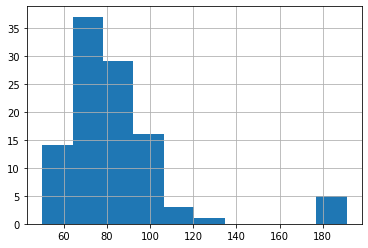

In [70]:
new_smoke['glucose'].hist()



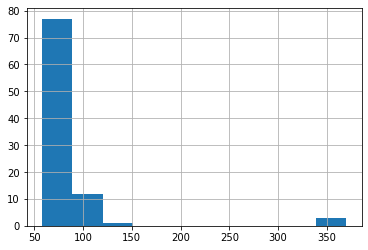

In [71]:
new_non['glucose'].hist()


4 ה


ניתן להשתמש במבחן וולד כי מתקיימים ראינו בהרצאה 3 שמתקיימים התנאים במקרה (אסימפטוטי נורמלי )של הפרש חציונים.


אך במבחן t אי אפשר להשתמש כי הנתונים לא מתפלגים נורמלית

5

In [72]:
df_sample["rank"] = df_sample['glucose'].rank()

sample_smoke = df_sample[df_sample['currentSmoker']==1]
sample_non =  df_sample[df_sample['currentSmoker']==0]
s1= sum(sample_smoke['rank'])

n= len(sample_smoke)
m = len(sample_non)
mu_s1 = n*(1+n+m)/2
se = ((n*m*(n+m+1))/12)**0.5
T= (s1- mu_s1)/se

print("normal approximation:")
if T>= stats.norm.ppf(0.95):
    print("Reject null hypothesis")
else:
    print("Accept null hypothesis")


######################################
bootstrap =[]

for i in range(B):
    new = df_sample.sample(B_sample_size, replace= True)
    new_smoke = new[new['currentSmoker']==1]
    su = sum(new_smoke['rank'])
    bootstrap.append(su)


    
counter = 0
for i in range(len(bootstrap)):
    if bootstrap[i]>= s1:
        counter+=1



print("           ")
p_val = counter/B
print("Estimated pvalue is: ", p_val)
print("according to permutations test:")
if p_val < 0.05:
    print("reject null hypothesis")
else:
    print("accept null hypothesis")

normal approximation:
Accept null hypothesis
           
Estimated pvalue is:  0.82
according to permutations test:
accept null hypothesis


המדגמים שבחרנו מספיק גדולים (שניהם מעל 85 )כדי שנוכל להפעיל קירוב בעזרת נורמליות.


קיבלנו בשתי המבחנים את אותה תוצאה, שאנחנו לא דוחים את השערת האפס




6

קיבלנו תוצאות דומות בכל המבחנים שביצענו בין אם בדרנו הפרשי ממוצעים ובין אם בדקנו הפרשי חציונים. הסיבה לכך היא שהפרשי הממוצעים מאוד קרובים להפרשי החציונים (פחות מ1) ולכן גם קיבלנו ערכי pvalue גבוהים יחסית

אם מסתכלים על ההיסטוגרמות קשה להגיד שזה נכון בגלל שרמת הגלוקוז מתפלגת שונה בין מעשנים ללא מעשנים. אך כשמסתכלים על המדדים הם כל כך קרובים כך שהנחנו מראש שלא נדחה את השערת האפס שלנו. 